<a href="https://colab.research.google.com/github/VeroGI/Supplement_Reviews/blob/main/Project_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro

In this project, I'm exploring the capabilities of the Hugging Face library for sentiment analysis on reviews of nutritional supplements. To do this, I've employed the same dataset utilized in the final project of my data science diploma, along with models that have demonstrated the best performance.

Specifically, I've chosen to use the bert-base-multilingual-uncased-sentiment model (BERT), which has been fine-tuned for sentiment analysis on product reviews across six languages, including Spanish. This model assigns a sentiment rating ranging from 1 to 5 stars to each review.

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install transformers -q
from transformers import pipeline
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB as ComplementNB_sk

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
import spacy
spacy.cli.download("es_core_news_sm")
import joblib



✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Upload file
from google.colab import files

uploaded = files.upload()

Saving ReviewsStars.xlsx to ReviewsStars (1).xlsx


In [56]:
datos = 'ReviewsStars.xlsx'
df = pd.read_excel(datos)

Sentiment analysis is conducted on every title within the 'Título' column employing a pre-existing BERT-based sentiment analysis model. The outcomes are stored in a newly created column named 'HF' within the original DataFrame.



In [57]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
classifier = pipeline("sentiment-analysis", model=model_name)

HF = []

for titulo in df['Título']:
    res = classifier(titulo)
    HF.append(res)


df['HF'] = HF


In [58]:
df.head()

,Nombre,Título,Reseña,Cantidad de Opiniones,Estrellas,País,Fecha Reseña,Verificada,HF
0,Jose Gallardo,Mejor comprar desde la página oficial,Mucho más informativa y ordenada que la página...,1 opinión,5,ES,2023-10-12,No disponible,"[{'label': '5 stars', 'score': 0.5639822483062..."
1,cliente,Como puede ser que sin previo aviso…,Como puede ser que sin previo aviso dejéis de ...,4 opiniones,1,ES,2023-10-05,Verificada,"[{'label': '5 stars', 'score': 0.2663534283638..."
2,Jose antonio García llorente,Los precios son los mejores y la…,"Los precios son los mejores y la calidad, pues...",2 opiniones,5,ES,2023-10-14,No disponible,"[{'label': '5 stars', 'score': 0.7408106327056..."
3,Mariló Andrade,Buena relación calidad precio y rápida entrega,Buenísima relación calidad precio y la entrega...,2 opiniones,5,ES,2023-10-05,Verificada,"[{'label': '4 stars', 'score': 0.5154177546501..."
4,javier,Llevo mucho tiempo comprando en esta…,"Llevo mucho tiempo comprando en esta empresa, ...",1 opinión,3,ES,2023-10-12,Verificada,"[{'label': '5 stars', 'score': 0.5783866643905..."


The score value is separated from the label and 2 new variables are created.

In [59]:
labels = []
scores = []

for item in df['HF']:
    label = int(item[0]['label'].split()[0])
    score = item[0]['score']
    labels.append(label)
    scores.append(score)

df['label_HF'] = labels
df['score'] = scores


In [60]:
df.head()

,Nombre,Título,Reseña,Cantidad de Opiniones,Estrellas,País,Fecha Reseña,Verificada,HF,label_HF,score
0,Jose Gallardo,Mejor comprar desde la página oficial,Mucho más informativa y ordenada que la página...,1 opinión,5,ES,2023-10-12,No disponible,"[{'label': '5 stars', 'score': 0.5639822483062...",5,0.563982
1,cliente,Como puede ser que sin previo aviso…,Como puede ser que sin previo aviso dejéis de ...,4 opiniones,1,ES,2023-10-05,Verificada,"[{'label': '5 stars', 'score': 0.2663534283638...",5,0.266353
2,Jose antonio García llorente,Los precios son los mejores y la…,"Los precios son los mejores y la calidad, pues...",2 opiniones,5,ES,2023-10-14,No disponible,"[{'label': '5 stars', 'score': 0.7408106327056...",5,0.740811
3,Mariló Andrade,Buena relación calidad precio y rápida entrega,Buenísima relación calidad precio y la entrega...,2 opiniones,5,ES,2023-10-05,Verificada,"[{'label': '4 stars', 'score': 0.5154177546501...",4,0.515418
4,javier,Llevo mucho tiempo comprando en esta…,"Llevo mucho tiempo comprando en esta empresa, ...",1 opinión,3,ES,2023-10-12,Verificada,"[{'label': '5 stars', 'score': 0.5783866643905...",5,0.578387


## Data preparation

In [61]:
x = df['Título']
y = df['Estrellas'].astype(int)


In [62]:
le = LabelEncoder()
y = le.fit_transform(y)

In [64]:
# text cleaning and lemmatization
nlp = spacy.load("es_core_news_sm")

def lemmatizar_y_limpiar(texto):
    texto = texto.lower()
    doc = nlp(texto)

    lemas = []

    for token in doc:
        lema = token.lemma_.lower()
        if not token.is_punct and not lema.isspace():
            lemas.append(lema)

    texto_lemmatizado = " ".join(lemas)
    return texto_lemmatizado

In [ ]:
# Upload stop words file
from google.colab import files

uploaded = files.upload()

Saving spanish.txt to spanish (1).txt


In [65]:
spanish = 'spanish.txt'

In [66]:
#Read the file and split the words into a list.
with open(spanish, 'r', encoding='utf-8') as archivo:
    stop_spanish = archivo.read().split()

In [67]:
print (stop_spanish)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosostros', 'vosostras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 

In [68]:
x = df['Título']
x=x.apply(lemmatizar_y_limpiar)

## Naive Bayes

Loading the trained Complement Naive Bayes model and the CountVectorizer

In [69]:
compNB = joblib.load('ModeloComplement.pkl')
vec3 = joblib.load('Vectorizador3.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ComplementNB from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [70]:
x_transf = vec3.transform(x)
compNB.score(x_transf, y)

0.8722539229671897

In [71]:
CNB = []
for indice, fila in df.iterrows():
    cnb = compNB.predict(x_transf)[indice]
    CNB.append(cnb)

df['CNB'] = CNB

In [72]:
print(df['CNB'])

0        4
1        0
2        4
3        4
4        4
        ..
14015    0
14016    4
14017    1
14018    3
14019    4
Name: CNB, Length: 14020, dtype: int32


In [73]:
# Recode prediction results by adding 1
df['CNB'] = df['CNB'] + 1

In [74]:
print(df['CNB'])

0        5
1        1
2        5
3        5
4        5
        ..
14015    1
14016    5
14017    2
14018    4
14019    5
Name: CNB, Length: 14020, dtype: int32


In [75]:
# Classification report
stars = ['1', '2', '3', '4', '5']
print(classification_report(y, CNB, target_names=stars))

              precision    recall  f1-score   support

           1       0.56      0.85      0.68       640
           2       0.40      0.64      0.49       247
           3       0.60      0.61      0.60       373
           4       0.68      0.36      0.47      1076
           5       0.93      0.93      0.93     11684

    accuracy                           0.87     14020
   macro avg       0.63      0.68      0.63     14020
weighted avg       0.88      0.87      0.87     14020



In [85]:
# Loading the TF-IDF Vectorizer + text vectorization
vecT = joblib.load('VectorizadorTFIdf.pkl')
x_transfLr=vecT.transform(x)
x_transfLr = x_transfLr.toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [86]:
#Loading the trained Neural Network model
model2 = tf.keras.models.load_model('./model.keras')

In [81]:
# Predictions for the entire data set
predictions = model2.predict(x_transfLr)

# Find the class with the highest probability for each row
NN = np.argmax(predictions, axis=1)

# Add the results as a new column called 'RED' to the DataFrame
df['NN'] = NN


439/439 [==============================] - 4s 8ms/step


In [82]:
# Classification report
print(classification_report(y, NN, target_names=stars))

              precision    recall  f1-score   support

           1       0.07      0.01      0.01       640
           2       0.02      0.27      0.04       247
           3       0.03      0.13      0.05       373
           4       0.11      0.00      0.00      1076
           5       0.84      0.63      0.72     11684

    accuracy                           0.54     14020
   macro avg       0.21      0.21      0.16     14020
weighted avg       0.71      0.54      0.61     14020



In [83]:
# Recode prediction results by adding 1
df['NN'] = df['NN'] + 1


In [84]:
print(df['NN'])

0        5
1        5
2        5
3        5
4        3
        ..
14015    2
14016    2
14017    3
14018    2
14019    5
Name: NN, Length: 14020, dtype: int64


## Logistic Regression

Loading the trained Logistic Regression model and the TF-IDF Vectorizer.

In [ ]:
#Loading trained logistic regression model
log = joblib.load('modelo_logreg.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [87]:
vecT=joblib.load('VectorizadorTFIdf.pkl')

In [88]:
x_transfLr=vecT.transform(x)

In [89]:
x_transfLr=x_transfLr.toarray()

In [90]:
log.score(x_transfLr, y)

0.8502139800285307

In [91]:
LR = log.predict(x_transfLr)
df['LOGREG'] = LR


In [92]:
# Clasification report
print(classification_report(y, LR, target_names=stars))

              precision    recall  f1-score   support

           1       0.77      0.31      0.44       640
           2       1.00      0.00      0.01       247
           3       0.60      0.05      0.09       373
           4       0.72      0.03      0.06      1076
           5       0.85      1.00      0.92     11684

    accuracy                           0.85     14020
   macro avg       0.79      0.28      0.30     14020
weighted avg       0.83      0.85      0.79     14020



In [93]:
# Recodifica los resultados de las predicciones sumando 1
df['LOGREG'] = df['LOGREG'] + 1


In [94]:
# Since HF has taken a long time to run, I decided to save the modified file
df.to_excel('Rev.xlsx', index=False)


In [95]:
a = df['Estrellas'].value_counts()
b = df['label_HF'].value_counts()
c = df['CNB'].value_counts()
d = df['NN'].value_counts()
e = df['LOGREG'].value_counts()
print(a)
print(b)
print(c)
print(d)
print(e)

5    11684
4     1076
1      640
3      373
2      247
Name: Estrellas, dtype: int64
5    11105
4     1237
1     1017
3      422
2      239
Name: label_HF, dtype: int64
5    11702
1      972
4      564
2      401
3      381
Name: CNB, dtype: int64
5    8820
2    3572
3    1550
1      60
4      18
Name: NN, dtype: int64
5    13687
1      256
4       46
3       30
2        1
Name: LOGREG, dtype: int64


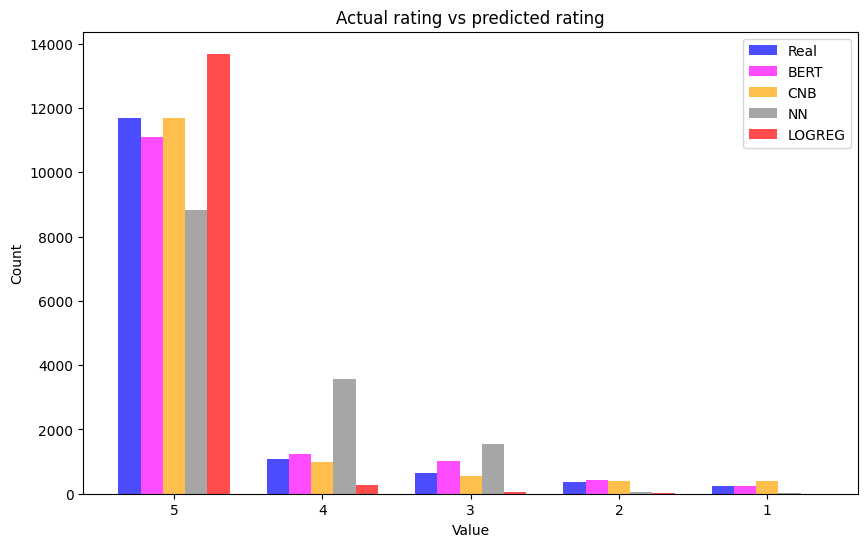

In [105]:
# Barplot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.15

data = [a, b, c, d, e]
colors = ['blue', 'magenta', 'orange', 'grey', 'red']
labels = ['Real', 'BERT', 'CNB', 'NN', 'LOGREG']

# Bars position
posiciones = [np.arange(len(values)) + bar_width * i for i, values in enumerate(data)]

# Bars
for i, values in enumerate(data):
    ax.bar(posiciones[i], values.values, width=bar_width, color=colors[i], alpha=0.7, label=labels[i])

ax.set_xticks(posiciones[0] + bar_width * 2)
ax.set_xticklabels(['5', '4', '3', '2', '1'])
ax.set_xlabel('Value')
ax.set_ylabel('Count')
ax.set_title('Actual rating vs predicted rating')
ax.legend()
ax.legend()

plt.show()


In [99]:
# Contingency table
tabla1 = pd.crosstab(df['label_HF'], df['Estrellas'], rownames=['Predicted BERT'], colnames=['Real'], margins=True)
print(tabla1)
tabla2 = pd.crosstab(df['CNB'], df['Estrellas'], rownames=['Predicted CNB'], colnames=['Real'], margins=True)
print(tabla2)
tabla3 = pd.crosstab(df['NN'], df['Estrellas'], rownames=['Predicted NN'], colnames=['Real'], margins=True)
print(tabla3)
tabla4 = pd.crosstab(df['LOGREG'], df['Estrellas'], rownames=['Predicted LOGREG'], colnames=['Real'], margins=True)
print(tabla4)


Real              1    2    3     4      5    All
Predicted BERT                                   
1               449  119   98    70    281   1017
2                61   40   47    26     65    239
3                39   32   81    95    175    422
4                19   15   59   236    908   1237
5                72   41   88   649  10255  11105
All             640  247  373  1076  11684  14020
Real             1    2    3     4      5    All
Predicted CNB                                   
1              547   49   34    40    302    972
2               15  159    9     8    210    401
3               15   16  227    14    109    381
4                8    3   16   385    152    564
5               55   20   87   629  10911  11702
All            640  247  373  1076  11684  14020
Real            1    2    3     4      5    All
Predicted NN                                   
1               4    1    1     5     49     60
2             180   67  103   263   2959   3572
3              8

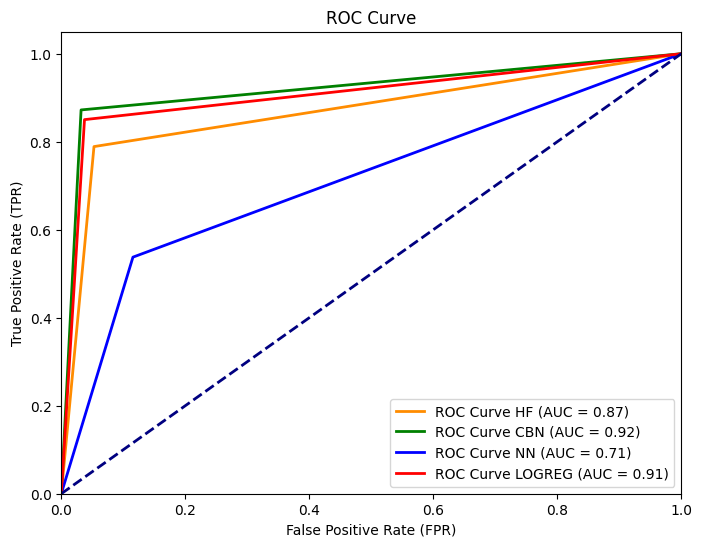

In [101]:
# ROC curve and AUC
y_true = df['Estrellas']
y_pred1 = df['label_HF']
y_pred2 = df['CNB']
y_pred3 = df['NN']
y_pred4 = df['LOGREG']

# Binarizar las etiquetas verdaderas y las predicciones
classes = [1, 2, 3, 4, 5]
y_true_bin = label_binarize(y_true, classes=classes)
y_pred1_bin = label_binarize(y_pred1, classes=classes)
y_pred2_bin = label_binarize(y_pred2, classes=classes)
y_pred3_bin = label_binarize(y_pred3, classes=classes)
y_pred4_bin = label_binarize(y_pred4, classes=classes)

# Calcular la curva ROC y el área bajo la curva (AUC) para cada clase
fpr1, tpr1, _ = roc_curve(y_true_bin.ravel(), y_pred1_bin.ravel())
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_true_bin.ravel(), y_pred2_bin.ravel())
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_true_bin.ravel(), y_pred3_bin.ravel())
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, _ = roc_curve(y_true_bin.ravel(), y_pred4_bin.ravel())
roc_auc4 = auc(fpr4, tpr4)

# Gráfica
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC Curve HF (AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', lw=2, label='ROC Curve CBN (AUC = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='blue', lw=2, label='ROC Curve NN (AUC = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='red', lw=2, label='ROC Curve LOGREG (AUC = %0.2f)' % roc_auc4)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## Conclusions

#### This is a very unbalanced dataset, and beyond observing acceptable accuracy values ​​for all models except the NN, it is observed that they fail quite a bit in classifying the minority classes.
##### The Complement Naive Bayes and Logistic Regression models present better metrics than Bert, however, it must be taken into account that the first 2 were previously trained with the same dataset, which is why they could be overfitting.
#### The objective of this project was to explore the Hugging Face and joblib libraries, so in another project I could test all the models with a new dataset.